### Functions

In [3]:
import numpy as np
import numpy.random as rn
from numba import jit, njit, prange
import matplotlib.pyplot as plt
from time import process_time




# @njit
# @jit(nopython=True, parallel=True)
def random_initial_state_generator(L, concentration): # Checked OK
    state = np.zeros((L, L, L))
    index_list = []


    for i in prange(L):
        for j in prange(L):
            for k in prange(L):
                if rn.rand() <= 0.5:
                    state[i, j, k] = -1
                else:
                    state[i, j, k] = 1

    for i in prange(L):
        for j in prange(L):
            for k in prange(L):
                index_list.append([i, j, k])

    rn.shuffle(index_list)

    for i in prange(int(round(((1 - concentration) * L * L * L), 5))):
        coordinate = index_list.pop(0)
        state[coordinate[0], coordinate[1], coordinate[2]] = 0
    
    return state



# @jit(nopython=True, parallel=True)
@njit
def initial_state_test(L, state):
    test_conc = 0

    for i in prange(L):
        for j in prange(L):
            for k in prange(L):
                if state[i, j, k] == 0:
                    test_conc += 1
    
    return (test_conc / (L * L * L))



# @jit(nopython=True, parallel=True)
@njit
def calculate_magnetization_per_spin(state, L): # Checked OK
  magnetization = 0

  for i in prange(L):
    for j in prange(L):
      for k in prange(L):
        magnetization += state[i, j, k]

  return magnetization / (L**3)



# @jit(nopython=True, parallel=True)
@njit
def calculate_energy_per_spin(state, L, J, B=0): # Checked OK
    energy_J = 0
    energy_B = 0

    for i in prange(L):
        for j in prange(L):
            for k in prange(L):
                i_prev = (i - 1) % L
                i_next = (i + 1) % L
                j_prev = (j - 1) % L
                j_next = (j + 1) % L
                k_prev = (k - 1) % L
                k_next = (k + 1) % L
                
                energy_J += -J * state[i, j, k] * (state[i_prev, j, k] + state[i_next, j, k] + state[i, j_prev, k] + state[i, j_next, k] + state[i, j, k_prev] + state[i, j, k_next])
                energy_B += -B * state[i, j, k]

    return (energy_J + energy_B) / (2 * L**3)



# @jit(nopython=True, parallel=True)
@njit
def next_state_generator(state, L):
    site = np.array([rn.randint(0, L - 1), rn.randint(0, L - 1), rn.randint(0, L - 1)])
    site_spin = state[site[0], site[1], site[2]]

    if site_spin == 1:
        state[site[0], site[1], site[2]] = -1
    elif site_spin == -1:
        state[site[0], site[1], site[2]] = 1

    return state, site



# @jit(nopython=True)
@njit
def change_in_energy(current_state, next_state, site, L, J, B=0):
    i = site[0]
    j = site[1]
    k = site[2]

    i_prev = (i - 1) % L
    i_next = (i + 1) % L
    j_prev = (j - 1) % L
    j_next = (j + 1) % L
    k_prev = (k - 1) % L
    k_next = (k + 1) % L

    current_state_site_energy = -J * current_state[i, j, k] * (current_state[i_prev, j, k] + current_state[i_next, j, k] + current_state[i, j_prev, k] + current_state[i, j_next, k] + current_state[i, j, k_prev] + current_state[i, j, k_next])

    next_state_site_energy = -J * next_state[i, j, k] * (next_state[i_prev, j, k] + next_state[i_next, j, k] + next_state[i, j_prev, k] + next_state[i, j_next, k] + next_state[i, j, k_prev] + next_state[i, j, k_next])

    return next_state_site_energy - current_state_site_energy



# @jit(nopython=True, parallel=True)
@njit
def central_difference_derivative(x_array, y_array):
    N = len(x_array)
    cnt_der = np.zeros((N - 2))

    for i in prange(1, N-1):
        cnt_der[i - 1] = (y_array[i + 1] - y_array[i - 1]) / (x_array [i + 1] - x_array[i - 1])
    
    return cnt_der



# @jit(nopython=True, parallel=True)
@njit
def ising_mc_thermalization(random_state, T, L, therm_steps, J):
    state = random_state.copy()

    for l in prange(therm_steps):
        for s in prange(L * L * L):
            next_state = state.copy()

            i = rn.randint(L)
            j = rn.randint(L)
            k = rn.randint(L)

            if next_state[i, j , k] == 0:
                break

            next_state[i, j , k] = -1 * state[i, j, k]
            energy_change = change_in_energy(state, next_state, [i, j, k], L, J)

            P_acc = np.exp(-1 * energy_change / T)

            if energy_change < 0:
                state = next_state.copy()
            
            elif rn.rand() <= P_acc:
                state = next_state.copy()

    return state



@njit
def ising_mc_simulation(thermalized_state, T, L, mc_steps, J, skip_step = 10):
    state = thermalized_state.copy()

    energy_per_spin = 0
    magnetization_per_spin_arr = np.zeros(((mc_steps // skip_step) + 1))

    for l in prange(mc_steps):
        for s in prange(L * L * L):
            next_state = state.copy()

            i = rn.randint(L)
            j = rn.randint(L)
            k = rn.randint(L)

            if next_state[i, j , k] == 0:
                break

            next_state[i, j , k] = -1 * state[i, j, k]
            energy_change = change_in_energy(state, next_state, [i, j, k], L, J)

            P_acc = np.exp(-1 * energy_change / T)

            if energy_change < 0:
                state = next_state.copy()
            
            elif rn.rand() <= P_acc:
                state = next_state.copy()
    
        if (l + 1) % skip_step == 0:
            energy_per_spin += calculate_energy_per_spin(state, L, J, B=0)
            magnetization_per_spin_arr[int((l + 1) / skip_step)] = calculate_magnetization_per_spin(state, L)
    
    magnetization_per_spin = magnetization_per_spin_arr.mean()
    
    susceptibility_per_spin = np.abs(((np.square(magnetization_per_spin_arr)).mean() - (magnetization_per_spin**2)) / T)
    
    return ((energy_per_spin * skip_step) / mc_steps), magnetization_per_spin, susceptibility_per_spin



### Main Code

Temperature Step: 1
Temperature: 10.0
Average Energy per Spin: -0.3074400000000002
Average Magnetization per Spin: 0.011306930693069308
Average Susceptibility per Spin: 0.00020964305460248995
CPU time taken: 0.828125
Temperature Step: 2
Temperature: 9.9
Average Energy per Spin: -0.317
Average Magnetization per Spin: 0.0005940594059405944
Average Susceptibility per Spin: 0.0002375801144470882
CPU time taken: 0.890625
Temperature Step: 3
Temperature: 9.8
Average Energy per Spin: -0.32716
Average Magnetization per Spin: -0.0021782178217821784
Average Susceptibility per Spin: 0.00018806303503658114
CPU time taken: 0.9375
Temperature Step: 4
Temperature: 9.7
Average Energy per Spin: -0.3174400000000001
Average Magnetization per Spin: 0.0005346534653465336
Average Susceptibility per Spin: 0.00022073607095322178
CPU time taken: 0.890625
Temperature Step: 5
Temperature: 9.6
Average Energy per Spin: -0.3278000000000001
Average Magnetization per Spin: 0.010019801980198022
Average Susceptibility 

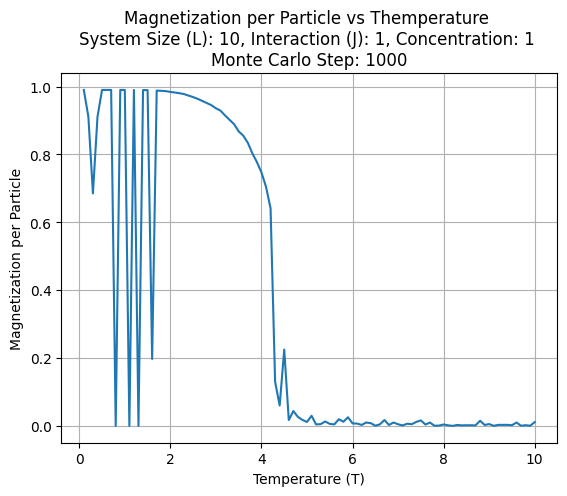

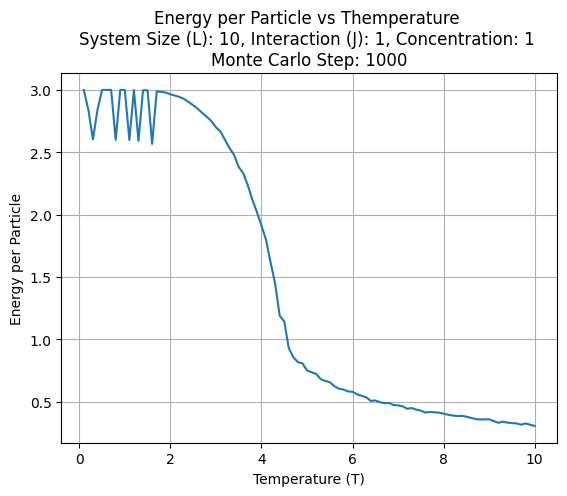

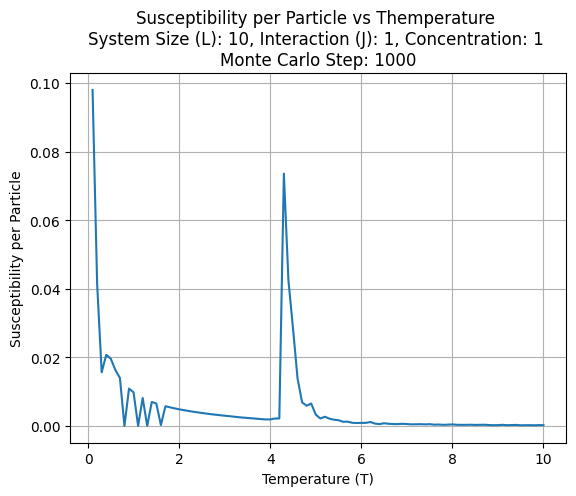

In [13]:
concentration = 1
J = 1
L = 10

T_0 = 10
T_max = 0.1
T_step_size = -0.1

therm_steps = 1000
mc_steps = 1000
skip_step = 10

temp_array = np.arange(T_0, T_max + T_step_size, T_step_size)
temp_array = np.round(temp_array, 3)

temp_step_no = len(temp_array)

energy_v_temp_arr = np.zeros((temp_step_no))
magnetization_v_temp_arr = np.zeros((temp_step_no))
susceptibility_v_temp_arr = np.zeros((temp_step_no))


for i, T in enumerate(temp_array):
    start_time = process_time()

    random_state = random_initial_state_generator(L, concentration)
    thermalized_state = ising_mc_thermalization(random_state, T, L, therm_steps, J)
    av_energy_per_spin, av_magnetization_per_spin, av_susceptibility_per_spin = ising_mc_simulation(thermalized_state, T, L, mc_steps, J, skip_step = skip_step)

    end_time = process_time()

    energy_v_temp_arr[i] = av_energy_per_spin
    magnetization_v_temp_arr[i] = av_magnetization_per_spin
    susceptibility_v_temp_arr[i] = av_susceptibility_per_spin

    print(f"Temperature Step: {i + 1}")
    print(f"Temperature: {T}")
    # print(av_energy_per_spin, '\n', av_magnetization_per_spin, '\n', av_susceptibility_per_spin)
    print(f"Average Energy per Spin: {av_energy_per_spin}")
    print(f"Average Magnetization per Spin: {av_magnetization_per_spin}")
    print(f"Average Susceptibility per Spin: {av_susceptibility_per_spin}")
    print(f"CPU time taken: {end_time - start_time}")


plt.plot(temp_array, np.abs(magnetization_v_temp_arr))
plt.title(f"Magnetization per Particle vs Themperature \nSystem Size (L): {L}, Interaction (J): {J}, Concentration: {concentration} \nMonte Carlo Step: {mc_steps}")
plt.xlabel("Temperature (T)")
plt.ylabel("Magnetization per Particle")
plt.grid()
plt.show()


plt.plot(temp_array, np.abs(energy_v_temp_arr))
plt.title(f"Energy per Particle vs Themperature \nSystem Size (L): {L}, Interaction (J): {J}, Concentration: {concentration} \nMonte Carlo Step: {mc_steps}")
plt.xlabel("Temperature (T)")
plt.ylabel("Energy per Particle")
plt.grid()
plt.show()


plt.plot(temp_array, susceptibility_v_temp_arr)
plt.title(f"Susceptibility per Particle vs Themperature \nSystem Size (L): {L}, Interaction (J): {J}, Concentration: {concentration} \nMonte Carlo Step: {mc_steps}")
plt.xlabel("Temperature (T)")
plt.ylabel("Susceptibility per Particle")
plt.grid()
plt.show()

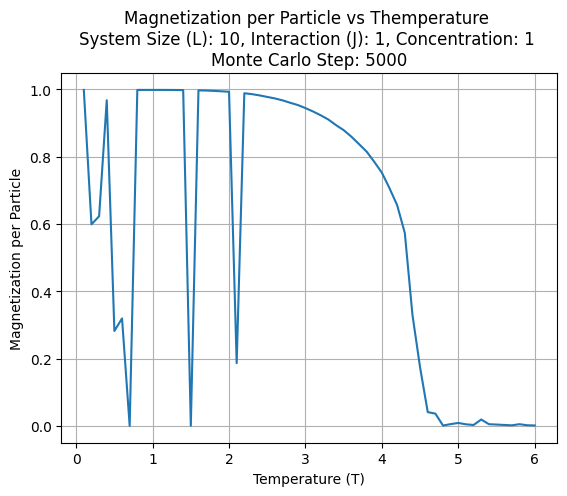

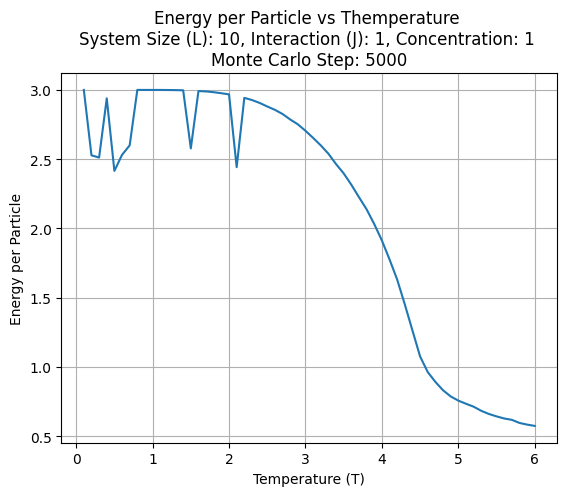

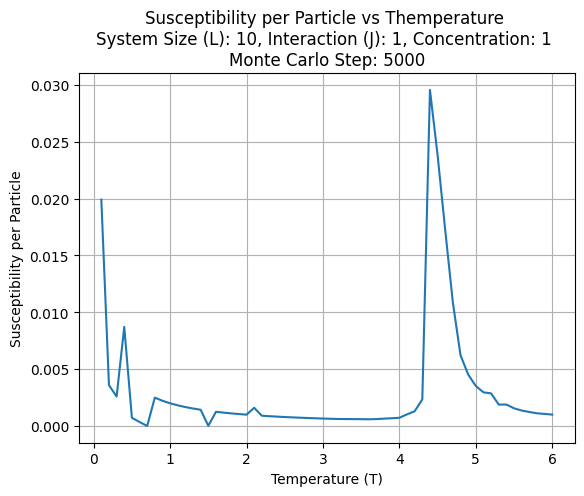

In [12]:
plt.plot(temp_array, np.abs(magnetization_v_temp_arr))
plt.title(f"Magnetization per Particle vs Themperature \nSystem Size (L): {L}, Interaction (J): {J}, Concentration: {concentration} \nMonte Carlo Step: {mc_steps}")
plt.xlabel("Temperature (T)")
plt.ylabel("Magnetization per Particle")
plt.grid()
plt.show()


plt.plot(temp_array, np.abs(energy_v_temp_arr))
plt.title(f"Energy per Particle vs Themperature \nSystem Size (L): {L}, Interaction (J): {J}, Concentration: {concentration} \nMonte Carlo Step: {mc_steps}")
plt.xlabel("Temperature (T)")
plt.ylabel("Energy per Particle")
plt.grid()
plt.show()


plt.plot(temp_array, susceptibility_v_temp_arr)
plt.title(f"Susceptibility per Particle vs Themperature \nSystem Size (L): {L}, Interaction (J): {J}, Concentration: {concentration} \nMonte Carlo Step: {mc_steps}")
plt.xlabel("Temperature (T)")
plt.ylabel("Susceptibility per Particle")
plt.grid()
plt.show()

In [4]:
T = 1
concentration = 1
J = 1
L = 10

therm_steps = 1000
mc_steps = 5000
skip_step = 10


start_time = process_time()

random_state = random_initial_state_generator(L, concentration)
thermalized_state = ising_mc_thermalization(random_state, T, L, therm_steps, J)
av_energy_per_spin, av_magnetization_per_spin, av_susceptibility_per_spin = ising_mc_simulation(thermalized_state, T, L, mc_steps, J, skip_step = skip_step)

end_time = process_time()

print(f"CPU time taken: {end_time - start_time}")

# print(av_energy_per_spin, '\n', av_magnetization_per_spin, '\n', av_susceptibility_per_spin)
print(f"Average Energy per Spin: {av_energy_per_spin}")
print(f"Average Magnetization per Spin: {av_magnetization_per_spin}")
print(f"Average Susceptibility per Spin: {av_susceptibility_per_spin}")

CPU time taken: 4.0625
Average Energy per Spin: -2.9999520000000004
Average Magnetization per Spin: 0.9979960079840319
Average Susceptibility per Spin: 0.0019920079680959546
